# Emojify
- We're going to use word vector representations to build an Emojifier
- Rather than writing 'Congratulations on the promotion! Let's get coffee and talk. Love you!'
- The emojifier can automatically turn this into : 
    - Congratulations on the promotion! 👍  Let's get coffee and talk. ☕️ Love you! ❤️
- We'll implement a model which inputs a sentecne and finds the most appropriate emoji to be used with the sentence.

## Using word vectors to improve Emoji Lookups
- In many emoji interfaces, we need to remember that ❤️ is the 'heart' symbok rather than the 'love' symbol
    - In other words, we'll have to remember to type 'heart' to find the desired emoji, and typing 'love' won't bring up that symbol.
- We can make a more flexible emoji interface by using word vectors!
- When using word vectors, we'll see that even if our training set explicity relates only a few words to a particular emoji, our algorithm will be able to generalize and associate additional words in the test set to the same emoji.
    - This works even if those additional words don't even appear in the training set.
    - This allows us to build an accurate classifier mapping from sentences to emojis, evem using a small training set.

- We'll build
     1. We'll start with a baseline model (Emojifier-V1) using word embeddings.
     2. Then we will build a more sophisticated model (Emojifier-V2) that further incorporates and LSTM
- We'll be able to : 
    - Create an embedding layer in keras with pre-trained word vectors
    - Explain the advantages and disadvatnages of the GloVe algorithm
    - Build a sentiment classifier using word embeddings
    - Build and train a more sophisticated classifier using an LSTM.

# Packages

In [4]:
import csv
import numpy as np
import emoji
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 1. Baseline Model : Emojifier-V1
## 1.1 Dataset EMOJISET
- Let's start by building a simple baseline classifier
- We have a tiny dataset (X, Y) where,
    - X contains 127 sentences (strings)
    - Y contains an integer label b/w 0 and 4 corresponding to an emoji for each sentence.
    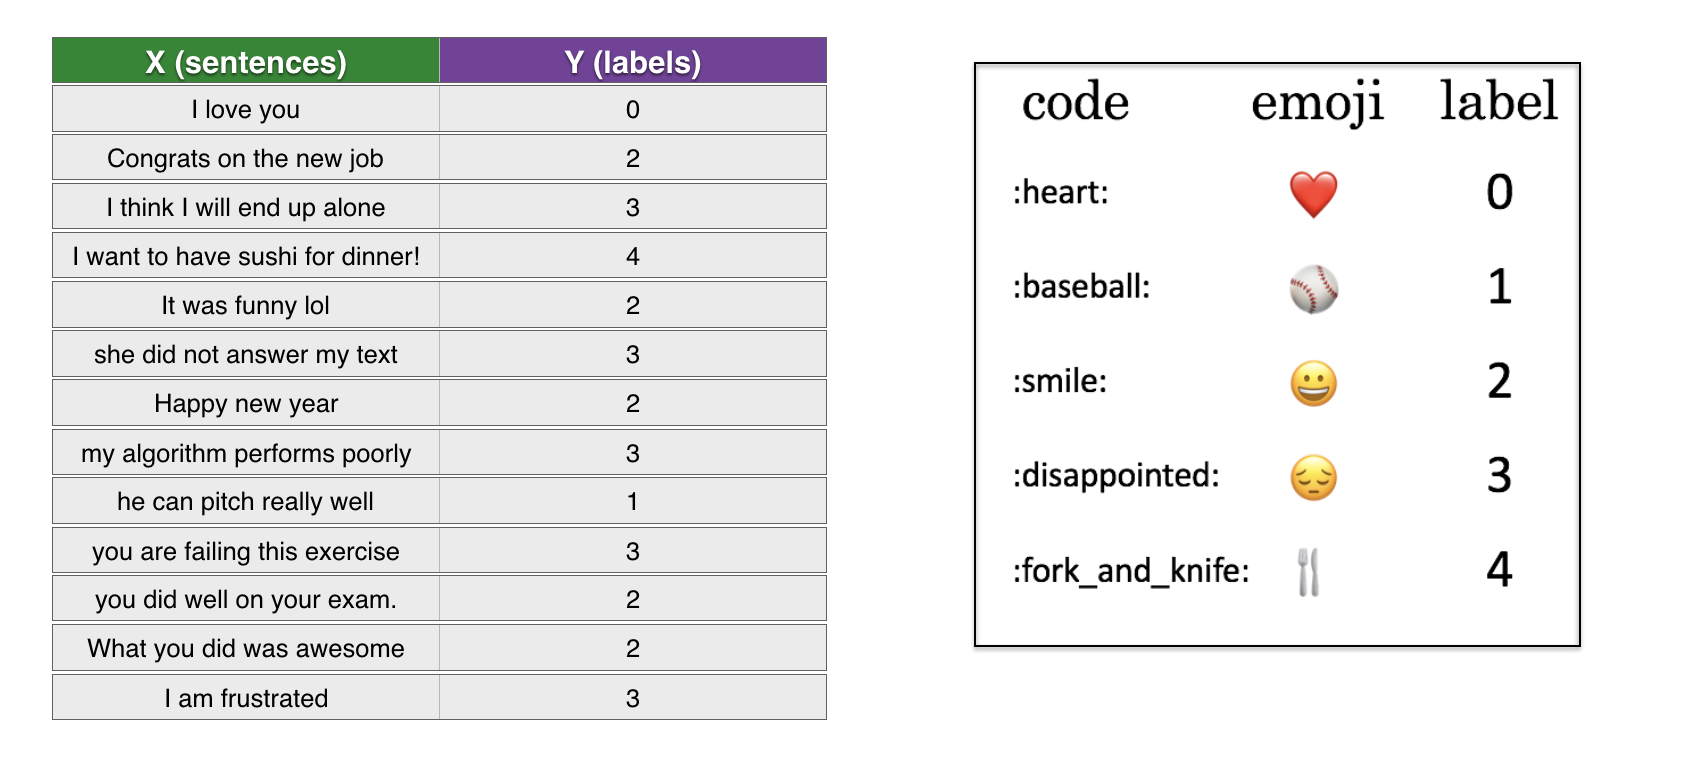
- The dataset is split b/w 127 training examples and 56 testing examples.

In [5]:
def read_csv(filename = 'data/emojify_data.csv'):
    phrase = []
    emoji = []

    with open (filename) as csvDataFile:
        csvReader = csv.reader(csvDataFile)

        for row in csvReader:
            phrase.append(row[0])
            emoji.append(row[1])

    X = np.asarray(phrase)
    Y = np.asarray(emoji, dtype=int)

    return X, Y

In [6]:
X_train, Y_train = read_csv('data/train_emoji.csv')
X_test, Y_test = read_csv('data/tesss.csv')

In [7]:
maxLen = len(max(X_train, key=lambda x: len(x.split())).split())

In [10]:
emoji_dictionary = {"0": "\u2764\uFE0F",    # :heart: prints a black instead of red heart depending on the font
                    "1": ":baseball:",
                    "2": ":smile:",
                    "3": ":disappointed:",
                    "4": ":fork_and_knife:"}

In [15]:
def label_to_emoji(label):
    """
    Converts a label (int or string) into the corresponding emoji code (string) ready to be printed
    """
    return emoji.emojize(emoji_dictionary[str(label)])

In [16]:
for idx in range(10):
    print(X_train[idx], label_to_emoji(Y_train[idx]))

never talk to me again :disappointed:
I am proud of your achievements :smile:
It is the worst day in my life :disappointed:
Miss you so much ❤️
food is life 🍴
I love you mum ❤️
Stop saying bullshit :disappointed:
congratulations on your acceptance :smile:
The assignment is too long  :disappointed:
I want to go play ⚾


## 1.2 Overview of the Emojifier-V1
- We'll implement a baseline model called 'Emojifier-V1'
- 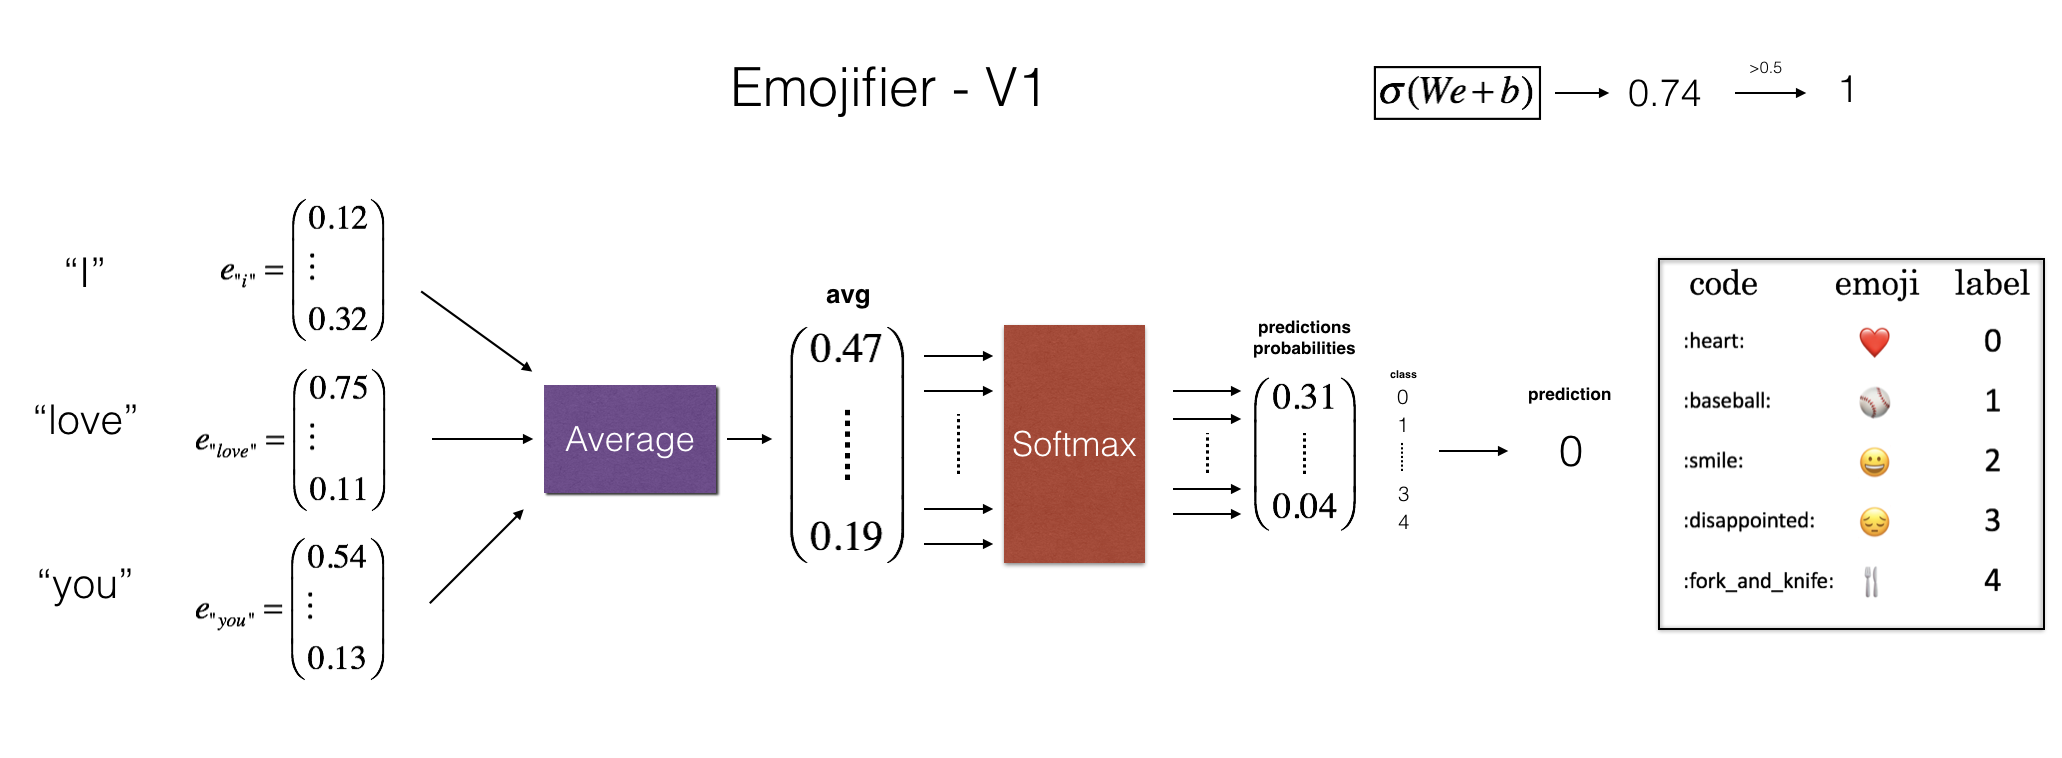

### Inputs and outputs
- The input of the model is a string corresponding to a sentence (e.g : 'I love you')
- The output will be a probability vector of shape (1, 5) (indicating that there are 5 emojis to choose from)
- The (1, 5) probability vector is passed to an argmax layer, which extracts the index of the emoji with the highest probability.

### One-hot Encoding
- To get our labels into a format suitable for training a softmax classifier, convert Y from its current shape (m, 1) into a one-hot representation (m 5)
    - Each row is a one-hot vector giving the label to one example.

In [17]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

In [18]:
Y_oh_train = convert_to_one_hot(Y_train, C = 5)
Y_oh_test = convert_to_one_hot(Y_test, C = 5)

In [19]:
idx = 50
print(f"Sentence '{X_train[idx]}' has label index {Y_train[idx]}, which is emoji {label_to_emoji(Y_train[idx])}", )
print(f"Label index {Y_train[idx]} in one-hot encoding format is {Y_oh_train[idx]}")

Sentence 'I missed you' has label index 0, which is emoji ❤️
Label index 0 in one-hot encoding format is [1. 0. 0. 0. 0.]


## 1.3 Implementing Emojifier-V1
- The 1st step is to : 
    1. Convert each word in the input sentence into their word vector representations.
    2. Take an average of the word vectors.

In [20]:
def read_glove_vecs(glove_file):
    with open(glove_file, 'r') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

In [ ]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('data/glove.6B.50d.txt')

- We've loaded
    - word_to_index : dictionary mapping from words to their indicies in the vocabulary
        - (400,001 wods, with the valid indicies ranging from 0 to 400,000)
     - index_to_word : dictionary mapping from indices to their corresponding words in the vocabulary.
     - word_to_vec_map : dictionary mapping words to their GloVe vector representation.

In [ ]:
word = "cucumber"
idx = 289846
print("the index of", word, "in the vocabulary is", word_to_index[word])
print("the", str(idx) + "th word in the vocabulary is", index_to_word[idx])

In [23]:
def sentence_to_avg(sentence, word_to_vec_map):
    """
    Converts a sentence (string) into a list of words (strings). Extracts the GloVe representation of each word
    and averages its value into a single vector encoding the meaning of the sentence.
    
    Arguments:
    sentence -- string, one training example from X
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    
    Returns:
    avg -- average vector encoding information about the sentence, numpy-array of shape (J,), where J can be any number
    """
    # Get a valid word contained in the word_to_vec_map. 
    any_word = next(iter(word_to_vec_map.keys()))
    
    ### START CODE HERE ###
    # Step 1: Split sentence into list of lower case words (≈ 1 line)
    words = sentence.lower().split()

    # Initialize the average word vector, should have the same shape as your word vectors.
    # Use `np.zeros` and pass in the argument of any word's word 2 vec's shape
    avg = np.zeros(word_to_vec_map[any_word].shape)
    
    # Initialize count to 0
    count = 0
    
    # Step 2: average the word vectors. You can loop over the words in the list "words".
    for w in words:
        # Check that word exists in word_to_vec_map
        if w in word_to_vec_map:
            avg += word_to_vec_map[w]
            # Increment count
            count +=1
          
    if count > 0:
        # Get the average. But only if count > 0
        avg = avg/count
    
    ### END CODE HERE ###
    
    return avg

## 1.4 Implement the Model
- We now have all the pieces to finish implementing the model() function. We need to : 
    - Pass the average through forward propagation
    - Compute the cost
    - Backpropagation to update the softmax parameters
- The equations we need to implement in the forward pass and to compute the cross-entropy cost are : 
     - 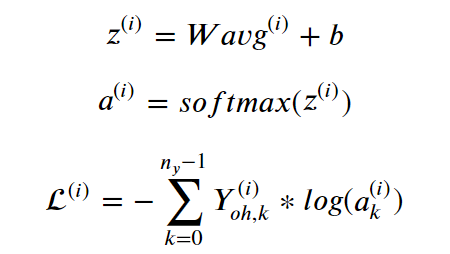

In [24]:
def model(X, Y, word_to_vec_map, learning_rate = 0.01, num_iterations = 400):
    """
    Model to train word vector representations in numpy.
    
    Arguments:
    X -- input data, numpy array of sentences as strings, of shape (m,)
    Y -- labels, numpy array of integers between 0 and 7, numpy-array of shape (m, 1)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    learning_rate -- learning_rate for the stochastic gradient descent algorithm
    num_iterations -- number of iterations
    
    Returns:
    pred -- vector of predictions, numpy-array of shape (m, 1)
    W -- weight matrix of the softmax layer, of shape (n_y, n_h)
    b -- bias of the softmax layer, of shape (n_y,)
    """
    
    # Get a valid word contained in the word_to_vec_map 
    any_word = next(iter(word_to_vec_map.keys()))
        
    # Define number of training examples
    m = Y.shape[0]                             # number of training examples
    n_y = len(np.unique(Y))                    # number of classes  
    n_h = word_to_vec_map[any_word].shape[0]   # dimensions of the GloVe vectors 
    
    # Initialize parameters using Xavier initialization
    W = np.random.randn(n_y, n_h) / np.sqrt(n_h)
    b = np.zeros((n_y,))
    
    # Convert Y to Y_onehot with n_y classes
    Y_oh = convert_to_one_hot(Y, C = n_y) 
    
    # Optimization loop
    for t in range(num_iterations): # Loop over the number of iterations
        
        cost = 0
        dW = 0
        db = 0
        
        for i in range(m):          # Loop over the training examples
            
            ### START CODE HERE ### (≈ 4 lines of code)
            # Average the word vectors of the words from the i'th training example
            # Use 'sentence_to_avg' you implemented above for this  
            avg = sentence_to_avg(X[i], word_to_vec_map)

            # Forward propagate the avg through the softmax layer. 
            # You can use np.dot() to perform the multiplication.
            z = np.dot(W, avg) + b
            a = softmax(z)

            # Add the cost using the i'th training label's one hot representation and "A" (the output of the softmax)
            cost += -np.sum(Y_oh[i]*np.log(a))
            ### END CODE HERE ###
            
            # Compute gradients 
            dz = a - Y_oh[i]
            dW += np.dot(dz.reshape(n_y,1), avg.reshape(1, n_h))
            db += dz

            # Update parameters with Stochastic Gradient Descent
            W = W - learning_rate * dW
            b = b - learning_rate * db
            
        assert type(cost) == np.float64, "Incorrect implementation of cost"
        assert cost.shape == (), "Incorrect implementation of cost"
        
        if t % 100 == 0:
            print("Epoch: " + str(t) + " --- cost = " + str(cost))
            pred = predict(X, Y, W, b, word_to_vec_map) #predict is defined in emo_utils.py

    return pred, W, b

- Word ordering isn't considered in the model
    - 'today is not good'
    - This algorithm ignores word ordering, so is not good at understanding phrases like 'not good'
    

# 2. Emojifier-V2 : Using LSTMs in Keras
- We're going to build an LSTM model that takes word sequences as input. This model will be able to account for word ordering
- Emojifier-V2 will continue to use pre-trained word embeddings to represents words. We'll feed word embedddings into an LSTM and the LSTM will learn to predict the most appropriate emoji.

In [25]:
import numpy as np
import tensorflow
np.random.seed(0)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.initializers import glorot_uniform
np.random.seed(1)

## 2.1 Model overview
- The Emojifier-V2 we will implement
- 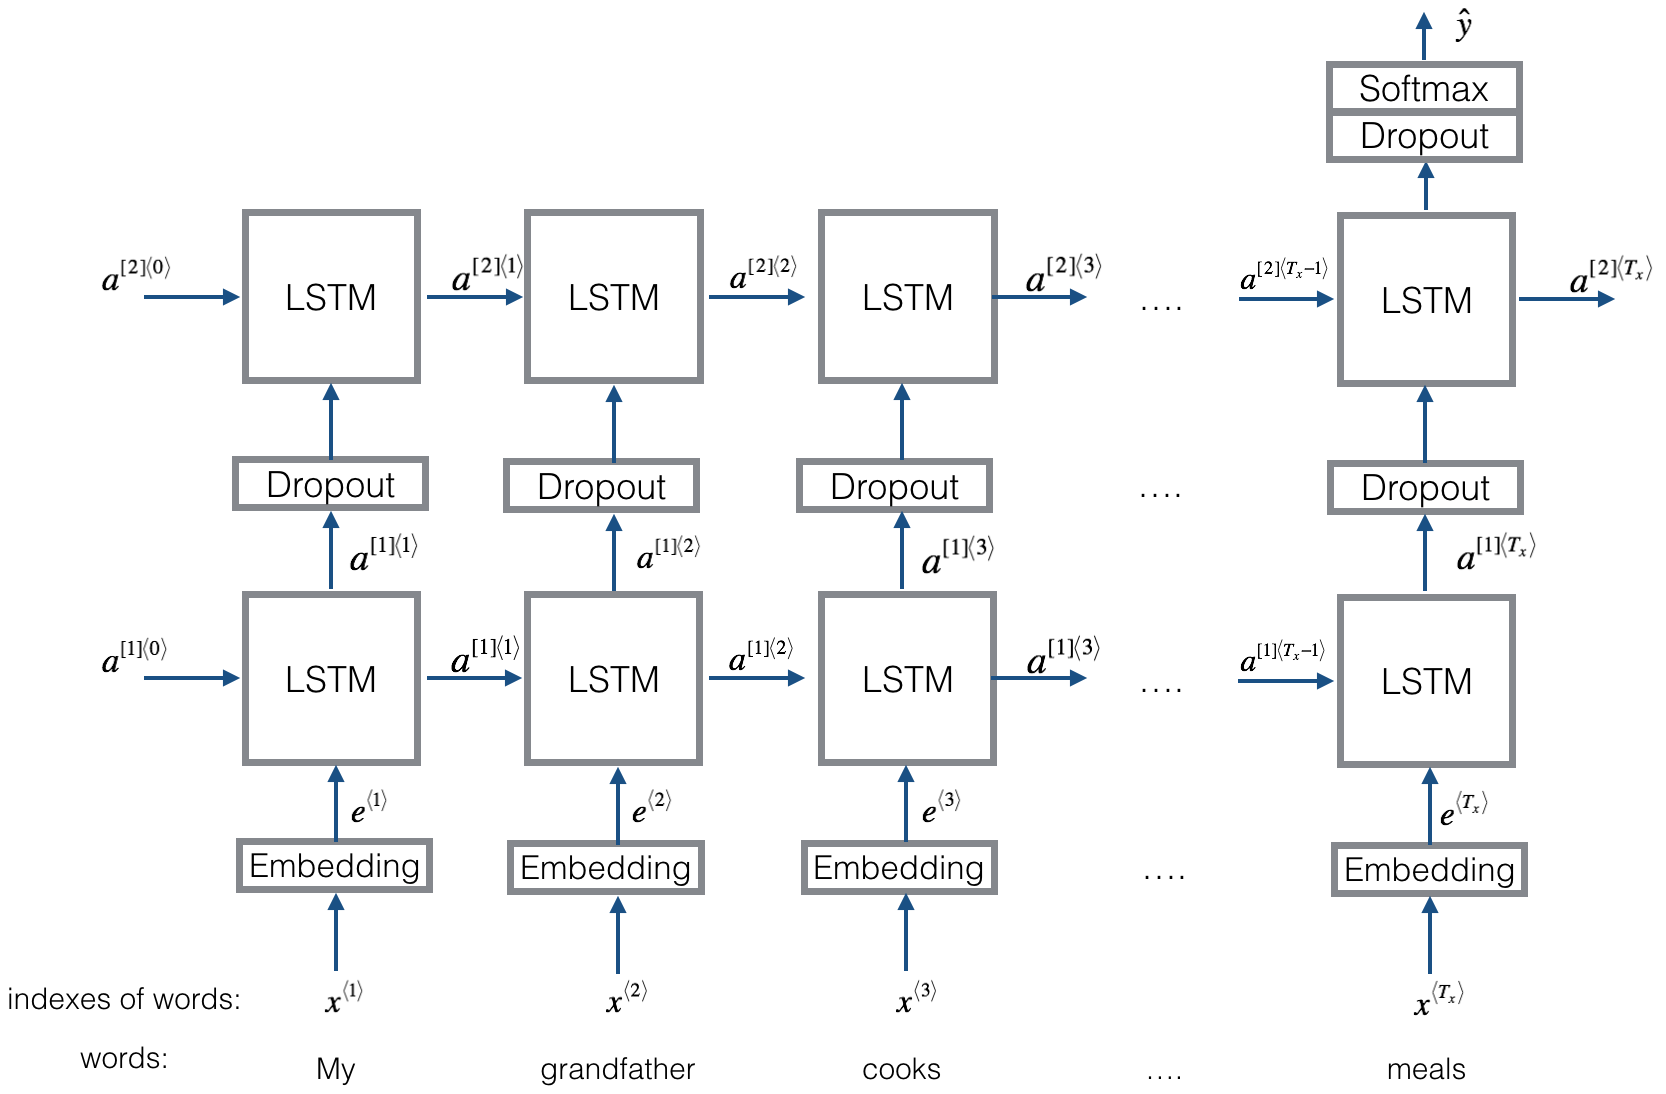

## 2.2 Keras and Mini-batching
- We want to train keras using mini-batches. However, most deep learning frameworks require that all sequences in the same mini-batch have the same length.
- If we has a 3-word sentence and a 4-word sentence, then the computations needed for them are different (one takes 3 steps of an LSTM, one takes 4 steps). So its just not possible to do them both at the same time.

### Padding handles sequences of varying length
- The common solution to handling sequence of different lenght is to use padding 
    - Set a maximum sequence length
    - Pad all sequences to have the same length
    
### Example of padding
- Given a maximum sequence length of 20, we could pad every sentecne with '0's so that each input sentence is of length 20
- Thus, the sentence 'I love you' would be represented as $(e_{I}, e_{love}, e_{you}, \vec{0}, \vec{0}, \ldots, \vec{0})$
- One way to choose the maximum sequence length is to pick the length of the longest sentence in the training set.

## 2.3 The Embedding Layer
- In keras, the embedding matrix represent as a 'layer'
- The embedding matrix maps word indices to embedding vectors.
    - The word indices are +ve integers.
    - The embedding vectors are dense vectors of fixes size.
    - A 'dense' vector is the opposite of a sparse vector. It means that most of its values are non-zero. As a counter-example, a one-hot encoded vector is not 'dense'
- The embedding matrix can be derived in 2 ways : 
    - Training a model to derive the embeddings from scratch
    - Using a pretrained embedding

### Using and updating Pre-trained Embeddings 
- We'll create an Embedding() layer in Keras
    - We will initialize the Embedding layer with GloVe 50-dimensional vectors.
    - We'll observe how keras allows us to either train or leave this layer fixed.
        - Because our training set is quite small, we'll leave the GloVe embeddings fixed instead of updating them.
        
### Inputs and Outputs to the Embedding layer
- The Embedding() layer's input is an integer matrix of size (batch size, max input length)
    - This input corresponds to sentecnes converted into list of indices (integers)
    - The largest integer (the highest word index) in the input should be no larger than the vocabulary size
- The embedding layer outputs and array of shape (batch size, max input length, dimension of word vectors)
- The figure shows the propagation of 2 example sentences through the embedding layer.
    - Both examples have been zero-paddes to a length of max_len=5
    - The word embedding are 50 units in length
    - The final dimension of the representation is (2, max_len, 50)
    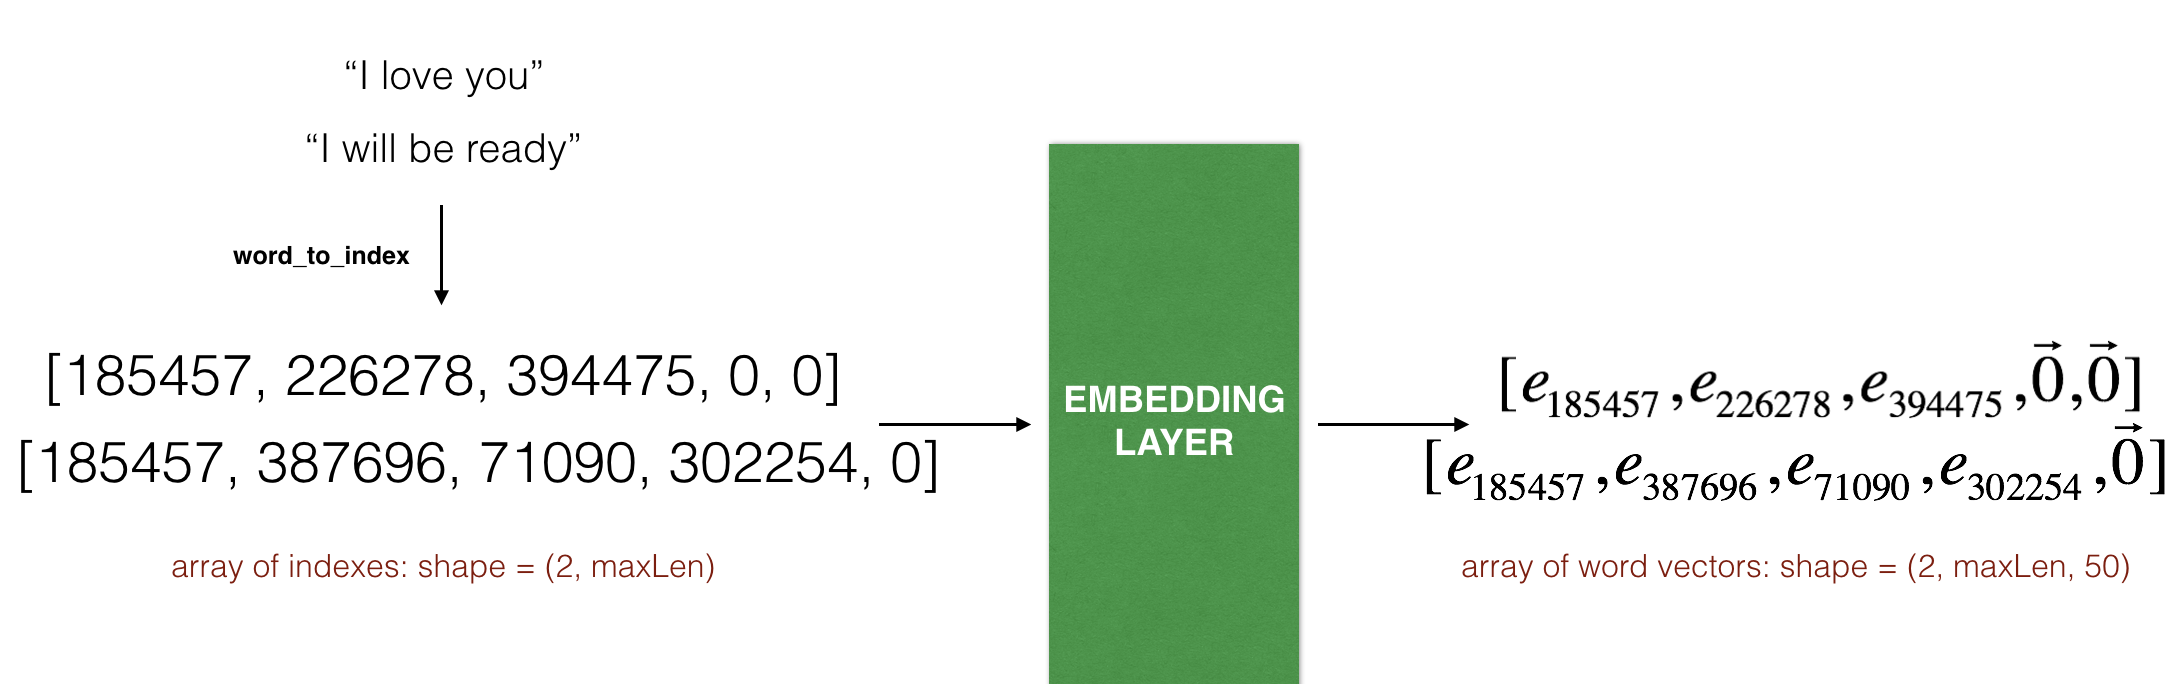

In [27]:
for idx, val in enumerate(["I", "like", "learning"]):
    print(idx, val)

0 I
1 like
2 learning


In [26]:
def sentences_to_indices(X, word_to_index, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can be given to `Embedding()` (described in Figure 4). 
    
    Arguments:
    X -- array of sentences (strings), of shape (m,)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this. 
    
    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """
    
    m = X.shape[0]                                   # number of training examples
    
    ### START CODE HERE ###
    # Initialize X_indices as a numpy matrix of zeros and the correct shape (≈ 1 line)
    X_indices = np.zeros((m, max_len))
    
    for i in range(m):                               # loop over training examples
        
        # Convert the ith training sentence to lower case and split it into words. You should get a list of words.
        sentence_words = X[i].lower().split()
        
        # Initialize j to 0
        j = 0
        
        # Loop over the words of sentence_words

        for w in sentence_words:
            # if w exists in the word_to_index dictionary
            if w in word_to_index:
                # Set the (i,j)th entry of X_indices to the index of the correct word.
                X_indices[i, j] = word_to_index[w]
                # Increment j to j + 1
                j =  j+1
            
    ### END CODE HERE ###
    
    return X_indices

### Build Embedding Layer
- Now, we'll build the Embedding() layer in Keras, using pre-trained word vectors.
    - The embedding layer takes s input a list of word indices
        - sentences_to_indicies() creates these word indices
    - The embedding layer will return the word embeddings for a sentence.

In [29]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    vocab_size = len(word_to_index) + 1              # adding 1 to fit Keras embedding (requirement)
    any_word = next(iter(word_to_vec_map.keys()))
    emb_dim = word_to_vec_map[any_word].shape[0]    # define dimensionality of your GloVe word vectors (= 50)
      
    ### START CODE HERE ###
    # Step 1
    # Initialize the embedding matrix as a numpy array of zeros.
    # See instructions above to choose the correct shape.
    emb_matrix = np.zeros((vocab_size, emb_dim))
    
    # Step 2
    # Set each row "idx" of the embedding matrix to be 
    # the word vector representation of the idx'th word of the vocabulary
    for word, idx in word_to_index.items():
        emb_matrix[idx, :] = word_to_vec_map[word]

    # Step 3
    # Define Keras embedding layer with the correct input and output sizes
    # Make it non-trainable.
    embedding_layer = Embedding(vocab_size, emb_dim, trainable=False)
    ### END CODE HERE ###

    # Step 4 (already done for you; please do not modify)
    # Build the embedding layer, it is required before setting the weights of the embedding layer. 
    embedding_layer.build((None,)) # Do not modify the "None".  This line of code is complete as-is.
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

## 2.4 Building the Emojifier V2
- We're ready to build the Emojifier-V2 model, in which we feed the embedding layer's output to an LSTM network
- 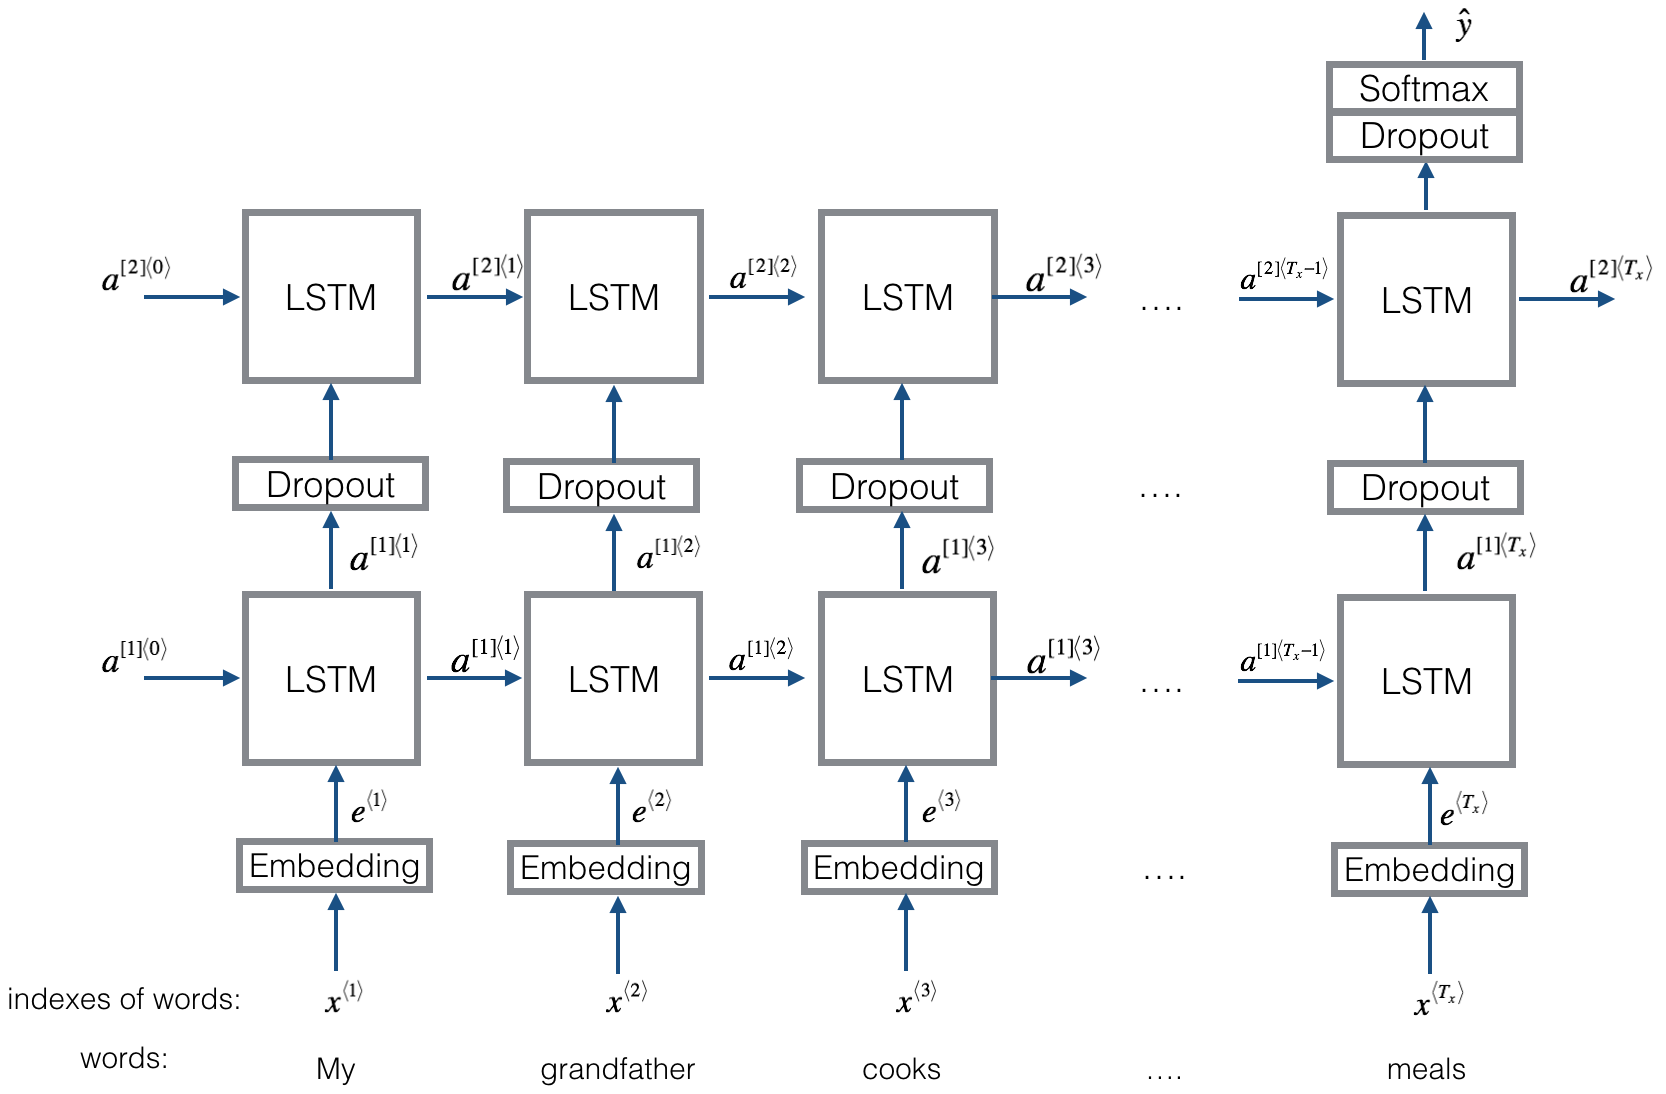

In [30]:
def Emojify_V2(input_shape, word_to_vec_map, word_to_index):
    """
    Function creating the Emojify-v2 model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """
    
    ### START CODE HERE ###
    # Define sentence_indices as the input of the graph.
    # It should be of shape input_shape and dtype 'int32' (as it contains indices, which are integers).
    sentence_indices = Input(shape=input_shape, dtype='int32')
    
    # Create the embedding layer pretrained with GloVe Vectors (≈1 line)
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    # Propagate sentence_indices through your embedding layer
    # (See additional hints in the instructions).
    embeddings = embedding_layer(sentence_indices)
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # The returned output should be a batch of sequences.
    X = LSTM(128,return_sequences=True)(embeddings)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X) 
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # The returned output should be a single hidden state, not a batch of sequences.
    X = LSTM(128, return_sequences=False)(X)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X) 
    # Propagate X through a Dense layer with 5 units
    X = Dense(5)(X)
    # Add a softmax activation
    X = Activation('softmax')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(sentence_indices, X)
    
    ### END CODE HERE ###
    
    return model

- If you have an NLP task where the training set is small, using word embeddings can help your algorithm significantly. 
- Word embeddings allow your model to work on words in the test set that may not even appear in the training set. 
- Training sequence models in Keras (and in most other deep learning frameworks) requires a few important details:
    - To use mini-batches, the sequences need to be **padded** so that all the examples in a mini-batch have the **same length**. 
    - An `Embedding()` layer can be initialized with pretrained values. 
        - These values can be either fixed or trained further on your dataset. 
        - If however your labeled dataset is small, it's usually not worth trying to train a large pre-trained set of embeddings.   
    - `LSTM()` has a flag called `return_sequences` to decide if you would like to return all hidden states or only the last one. 
    - You can use `Dropout()` right after `LSTM()` to regularize your network. 